# process spectra for AuxTel with new spectractor (version=2.5, July 2023, branch  master)

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : July 18th 2023
- update : 2023-07-18 

- version v4 : Work with exposure butlen gen3

This notebook is to help for finding the position of order 0

CCIN2P3:

- works with the new kernel **anaconda3_py39_auxtel** (with libradtran) 



# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.path)

['/Users/sylvie/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2023_07', '/Users/sylvie/mambaforge/lib/python310.zip', '/Users/sylvie/mambaforge/lib/python3.10', '/Users/sylvie/mambaforge/lib/python3.10/lib-dynload', '', '/Users/sylvie/mambaforge/lib/python3.10/site-packages', '/Users/sylvie/mambaforge/lib/python3.10/site-packages/Spectractor-2.5-py3.10.egg', '/Users/sylvie/mambaforge/lib/python3.10/site-packages/docopt-0.6.2-py3.10.egg', '/Users/sylvie/mambaforge/lib/python3.10/site-packages/certifi-2023.5.7-py3.10.egg', '/Users/sylvie/mambaforge/lib/python3.10/site-packages/webencodings-0.5.1-py3.10.egg']


In [3]:
all_paths_to_remove = ['/opt/conda/lib/python3.8/site-packages','/pbs/home/d/dagoret/.local/lib/python3.8/site-packages']

for path_to_remove in all_paths_to_remove:
    if path_to_remove in sys.path:
        print(f"remove {path_to_remove} from sys.path")
        sys.path.remove(path_to_remove)

In [4]:
sys.path

['/Users/sylvie/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2023_07',
 '/Users/sylvie/mambaforge/lib/python310.zip',
 '/Users/sylvie/mambaforge/lib/python3.10',
 '/Users/sylvie/mambaforge/lib/python3.10/lib-dynload',
 '',
 '/Users/sylvie/mambaforge/lib/python3.10/site-packages',
 '/Users/sylvie/mambaforge/lib/python3.10/site-packages/Spectractor-2.5-py3.10.egg',
 '/Users/sylvie/mambaforge/lib/python3.10/site-packages/docopt-0.6.2-py3.10.egg',
 '/Users/sylvie/mambaforge/lib/python3.10/site-packages/certifi-2023.5.7-py3.10.egg',
 '/Users/sylvie/mambaforge/lib/python3.10/site-packages/webencodings-0.5.1-py3.10.egg']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [6]:
print(sys.executable)
print(sys.version)
#print(sys.version_info)

/Users/sylvie/mambaforge/bin/python
3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:24:27) [Clang 14.0.6 ]


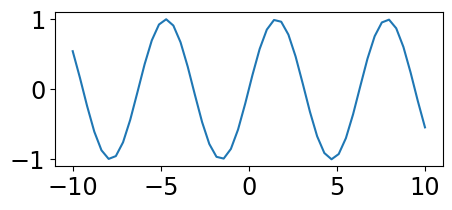

In [7]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               


In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.21.3'

In [10]:
import scipy
print(scipy.__version__)

1.10.1


In [11]:
from astropy.io import fits
from astropy.coordinates import Angle
from astropy import units as u
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor,dumpParameters
#dumpfitparameters
from spectractor.extractor.images import *
from spectractor.config import load_config, set_logger
from scipy import ndimage, misc

In [12]:
import logging

In [13]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [14]:
from distutils.dir_util import copy_tree
import shutil

In [15]:
from astroquery.simbad import Simbad
import astroquery
astroquery.__version__
result_table = Simbad.query_object("M1")

In [16]:
def find_target_name(tag):
    try:
        target_name=tag
        result_table = Simbad.query_object(target_name)
        return target_name
    except:
        target_name_stripped = ''.join(tag.split())
        result_table = Simbad.query_object(target_name_stripped)
        return target_name_stripped 
           

# Configuration

## Logger

In [17]:
my_logger = logging

## Config for the notebook

In [18]:
version="v6.0"  # version for taking images from data/2023 (images come from usdf)
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True
FLAG_RUNWITHEXCEPTIONS = False

## Configuration for Spectractor

In [19]:
print("List of configuration files available : ",os.listdir("config"))

List of configuration files available :  ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini', '.ipynb_checkpoints', 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini']


In [20]:
# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_FFMv_REBIN1_Janv2023.ini']

config_idx = len(list_of_spectractorconfigfiles)-2
                                
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [21]:
configfilename

'./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini'

In [22]:
configdir

'config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [23]:
! pwd

/Users/sylvie/MacOSX/GitHub/LSST/AuxTelComm/notebookccdm_gen3/runspectractor_standalone/2023_07


In [24]:
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini


In [25]:
load_config(configfilename)

In [26]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 2048
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.1904
CCD_PIXEL2MM 0.02
CCD_REBIN 2
CONFIG_DIR ../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR extractor/dispersers/
DISPLAY True
DISTANCE2CCD 181
DISTANCE2CCD_ERR 0.4
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
LAMBDAS [ 300  301  302  303  304  305  306  307  308  309  310  311  312  313
  314  315  316  317  318  319  320  321  322  323  324  325  326  327
  328  329  330  331  332  333  334  335  336  337  338  339  340  341
  342  343  344  345  346  347  348  349  350  351  352  353  354  355
  356  357  358  359  360  361  362  363  364  365  366  367  368  369
  370  371  372  373  374  375  376  377  378  379  380  381  382  383
  384  385  386  387  388  389  390  391  392  393  394  395  396  397
  39

# Exposure config

In [27]:
! ls logbooks

auxtellogbook_empty~holo4_003_20230117_v6.0.csv
auxtellogbook_empty~holo4_003_20230117_v6.0.xlsx
auxtellogbook_empty~holo4_003_20230118_v6.0.csv
auxtellogbook_empty~holo4_003_20230118_v6.0.xlsx
auxtellogbook_empty~holo4_003_20230119_v6.0.csv
auxtellogbook_empty~holo4_003_20230119_v6.0.xlsx


In [28]:
# path index for each month
DATE="20230117"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
#filterdispersername = "FELH0600~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [29]:
disperser_label = filterdispersername.split("~")[-1]

## Paths

In [30]:
# select if we run at CC or not (locally) 
# /sps/lsst/groups/auxtel/data/2022/holo/20220317
HOSTCC=False
LAPTOP=False

In [31]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2023"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2023/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2023/OutputSpectractor/"+imagemode)
        


In [32]:
path_images

'/Users/sylvie/DATA/AuxTelData2023/data/2023/empty~holo4_003/20230117'

In [33]:
path_topoutput_spectractor

'/Users/sylvie/DATA/AuxTelData2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [34]:
path_output_spectractor

'/Users/sylvie/DATA/AuxTelData2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230117'

# Utility Functions

In [35]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [36]:
!ls logbooks

auxtellogbook_empty~holo4_003_20230117_v6.0.csv
auxtellogbook_empty~holo4_003_20230117_v6.0.xlsx
auxtellogbook_empty~holo4_003_20230118_v6.0.csv
auxtellogbook_empty~holo4_003_20230118_v6.0.xlsx
auxtellogbook_empty~holo4_003_20230119_v6.0.csv
auxtellogbook_empty~holo4_003_20230119_v6.0.xlsx


In [37]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [38]:
filename_logbook

'logbooks/auxtellogbook_empty~holo4_003_20230117_v6.0.csv'

In [39]:
df=pd.read_csv(filename_logbook,index_col=0)

In [40]:
pd.set_option('display.max_rows', None)

In [41]:
# show the list of input files from the logbook to select the file index in the logbook
df

index                     date   
0       0  2023-01-18T02:34:49.018  \
1       1  2023-01-18T02:44:20.249   
2       2  2023-01-18T02:45:03.252   
3       3  2023-01-18T03:05:35.183   
4       4  2023-01-18T03:06:18.107   
5       5  2023-01-18T03:18:40.594   
6       6  2023-01-18T03:19:23.524   
7       7  2023-01-18T03:24:35.922   
8       8  2023-01-18T03:25:18.849   
9       9  2023-01-18T03:38:30.056   
10     10  2023-01-18T03:39:12.919   
11     11  2023-01-18T03:48:52.160   
12     12  2023-01-18T03:49:35.150   
13     13  2023-01-18T04:05:23.766   
14     14  2023-01-18T04:06:06.773   
15     15  2023-01-18T04:10:49.868   
16     16  2023-01-18T04:11:32.872   
17     17  2023-01-18T04:16:17.352   
18     18  2023-01-18T04:17:00.167   
19     19  2023-01-18T04:28:21.261   
20     20  2023-01-18T04:29:04.171   
21     21  2023-01-18T04:40:47.514   
22     22  2023-01-18T04:41:30.443   
23     23  2023-01-18T04:50:55.069   
24     24  2023-01-18T04:51:38.086   
25     25  2023-01-18T05:02:55.005   
26     26  2023-01-18T05:03:37.923   
27     27  2023-01-18T05:28:19.654   
28     28  2023-01-18T05:29:02.654   
29     29  2023-01-18T05:33:57.409   
30     30  2023-01-18T05:34:40.240   
31     31  2023-01-18T05:39:27.315   
32     32  2023-01-18T05:40:10.136   
33     33  2023-01-18T05:45:11.424   
34     34  2023-01-18T05:45:54.259   
35     35  2023-01-18T05:51:23.728   
36     36  2023-01-18T05:52:06.548   
37     37  2023-01-18T05:58:05.153   
38     38  2023-01-18T05:58:48.140   
39     39  2023-01-18T06:04:01.735   
40     40  2023-01-18T06:04:44.550   
41     41  2023-01-18T06:09:30.044   
42     42  2023-01-18T06:10:13.049   
43     43  2023-01-18T06:15:24.477   
44     44  2023-01-18T06:16:07.458   
45     45  2023-01-18T06:21:17.194   
46     46  2023-01-18T06:22:00.031   
47     47  2023-01-18T06:27:29.678   
48     48  2023-01-18T06:28:12.596   
49     49  2023-01-18T06:33:45.227   
50     50  2023-01-18T06:34:28.219   
51     51  2023-01-18T06:47:58.513   
52     52  2023-01-18T06:48:41.417   
53     53  2023-01-18T06:53:55.067   
54     54  2023-01-18T06:54:38.029   
55     55  2023-01-18T07:00:07.145   
56     56  2023-01-18T07:00:49.983   
57     57  2023-01-18T07:06:32.633   
58     58  2023-01-18T07:07:15.540   
59     59  2023-01-18T07:12:01.101   
60     60  2023-01-18T07:12:43.924   
61     61  2023-01-18T07:17:48.197   
62     62  2023-01-18T07:18:31.080   
63     63  2023-01-18T07:34:48.229   
64     64  2023-01-18T07:35:31.223   
65     65  2023-01-18T07:40:57.481   
66     66  2023-01-18T07:41:40.511   
67     67  2023-01-18T07:47:11.127   
68     68  2023-01-18T07:47:54.074   
69     69  2023-01-18T07:52:39.845   
70     70  2023-01-18T07:53:22.805   
71     71  2023-01-18T08:06:45.474   
72     72  2023-01-18T08:07:28.408   
73     73  2023-01-18T08:18:50.522   
74     74  2023-01-18T08:19:33.429   
75     75  2023-01-18T08:30:51.361   
76     76  2023-01-18T08:31:34.220   
77     77  2023-01-18T08:36:18.416   
78     78  2023-01-18T08:37:01.400   
79     79  2023-01-18T08:42:14.226   
80     80  2023-01-18T08:42:57.080   
81     81  2023-01-18T08:48:32.005   
82     82  2023-01-18T08:49:14.813   

                                                 path   
0   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...  \
1   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
2   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
3   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
4   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
5   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
6   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
7   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
8   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
9   /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
10  /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
11  /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
12  /Users/sylvie/DATA/AuxTelData2023/data/2023/em...   
13  /Users/sy

# Selection of input file
- the input file is selected from the logbook list above

In [42]:
idx=1

In [43]:
print(df.iloc[idx]['file'])

exposure_2023011700243_pseudo-postisrccd.fits


In [44]:
print(df.iloc[idx])

index                                                          1
date                                     2023-01-18T02:44:20.249
path           /Users/sylvie/DATA/AuxTelData2023/data/2023/em...
file               exposure_2023011700243_pseudo-postisrccd.fits
num                                                          243
object                                                  HD074000
filter                                                   empty_1
disperser                                              holo4_003
airmass                                                 1.335267
exposure                                                    30.0
focus                                                        0.0
seeing                                                      1.15
pressure                                                   744.0
temperature                                                 10.0
humidity                                                    50.0
windspd                  

In [45]:
myhome=os.getenv("HOME")

In [46]:
dir_images=path_images

In [47]:
dir_images

'/Users/sylvie/DATA/AuxTelData2023/data/2023/empty~holo4_003/20230117'

In [48]:
filename_image=df['file'][idx]
filename_image

'exposure_2023011700243_pseudo-postisrccd.fits'

In [49]:
target = df['object'][idx]
target

'HD074000'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [50]:
# ## If order 0 position exists in logbook it is selected, otherwise put it by hand

x0=300
y0=1700

if 'Obj-posXpix' in df.columns and 'Obj-posYpix' in df.columns:
    thex0 = df['Obj-posXpix'][idx]
    if not is_nan(thex0):
        x0=thex0
    they0 = df['Obj-posYpix'][idx]
    if not is_nan(they0):
        y0=they0
    
if not is_nan(x0) and not is_nan(y0):

    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

print(f"guess (x0,y0) = ({x0},{y0})")


Order 0 location from logbook : (300,1700)
guess (x0,y0) = (300,1700)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [51]:
rootfilename = filename_image.split(".")[0]
rootfilename_split =  rootfilename.split("_") 
filenumberdir = rootfilename_split[1] 

In [52]:
path_output_spectractor

'/Users/sylvie/DATA/AuxTelData2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230117'

In [53]:
configdir

'config_DECONVOLUTION_FFMv_REBIN2_Janv2023'

In [54]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
#subdir=filename_image.split(".")[0]
subdir=filenumberdir

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)


# local directories to put spectra and plots
    
if configdir =="":
    output_directory="./outputs_process_" + DATE  + '_' + dispersername +'_nb_' + str(idx+1)
    output_figures="figures_process_" + DATE + '_' + dispersername + '_nb_' + str(idx+1)
else:
    output_directory = "./outputs_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    output_figures   = "./figures_process_"+ DATE +"_"+ filterdispersername + "_" + configdir + "_nb_" + str(idx+1)
    
    

#guess = [300,1700]
guess = [350,1700]

# configuration

config=configfilename    
target=df.iloc[idx]["object"]

In [55]:
print(f"finalpath_output_spectractor = {finalpath_output_spectractor}")
print(f"output_directory = {output_directory}")
print(f"output_figures = {output_figures}")
print(f"config filename = {config}")

finalpath_output_spectractor = /Users/sylvie/DATA/AuxTelData2023/data/2023/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_FFMv_REBIN2_Janv2023/20230117/2023011700243
output_directory = ./outputs_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2
output_figures = ./figures_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2
config filename = ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini


In [56]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [57]:
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    cleandir(output_directory)
    
# manage subdirs spectrum/ and plots/

if not os.path.isdir(output_figures):
    os.mkdir(output_figures)
else:
    cleandir(output_figures)

# Configuration of the Spectractor running mode

In [58]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [59]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [60]:
target_name_sel0 = find_target_name(target)
print(f"target_name_sel0 = {target_name_sel0}")
#target_name_sel0 = ''.join(target.split())
#target_name_sel1 = target_name_sel0.encode(encoding='UTF-8',errors='strict')
#target_name_sel = target_name_sel0.encode()
target_name_sel = target_name_sel0.encode(encoding="ascii", errors="ignore")
print(f'target_name_sel = {target_name_sel}')
#target_name_sel=f"{target_name_sel}"

target_name_sel0 = HD074000
target_name_sel = b'HD074000'


## Load the image in the new image file with Spectractor

In [61]:
image=Image(file_name=filename, disperser_label=disperser_label,target_label=target_name_sel, config=config)

2023-07-18 16:12:25  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=4.24556561933527 but average of self.read_out_noise is 8.5.


In [62]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [63]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [64]:
image.header["FILTER"]

'empty_1'

In [65]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CCD_MANU= 'ITL     '                                                            
CCD_TYPE= '3800C   '                                                            
BINX    =                    1                                                  
BINY    =                    1                                                  
CCDGAIN =                  1.0                                                  
CCDNOISE=                 10.0                                                  
CCDSLOT = 'S00     '                                                            
RAFTBAY = 'R00     '                                                            
FIRMWARE= '11384004'        

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

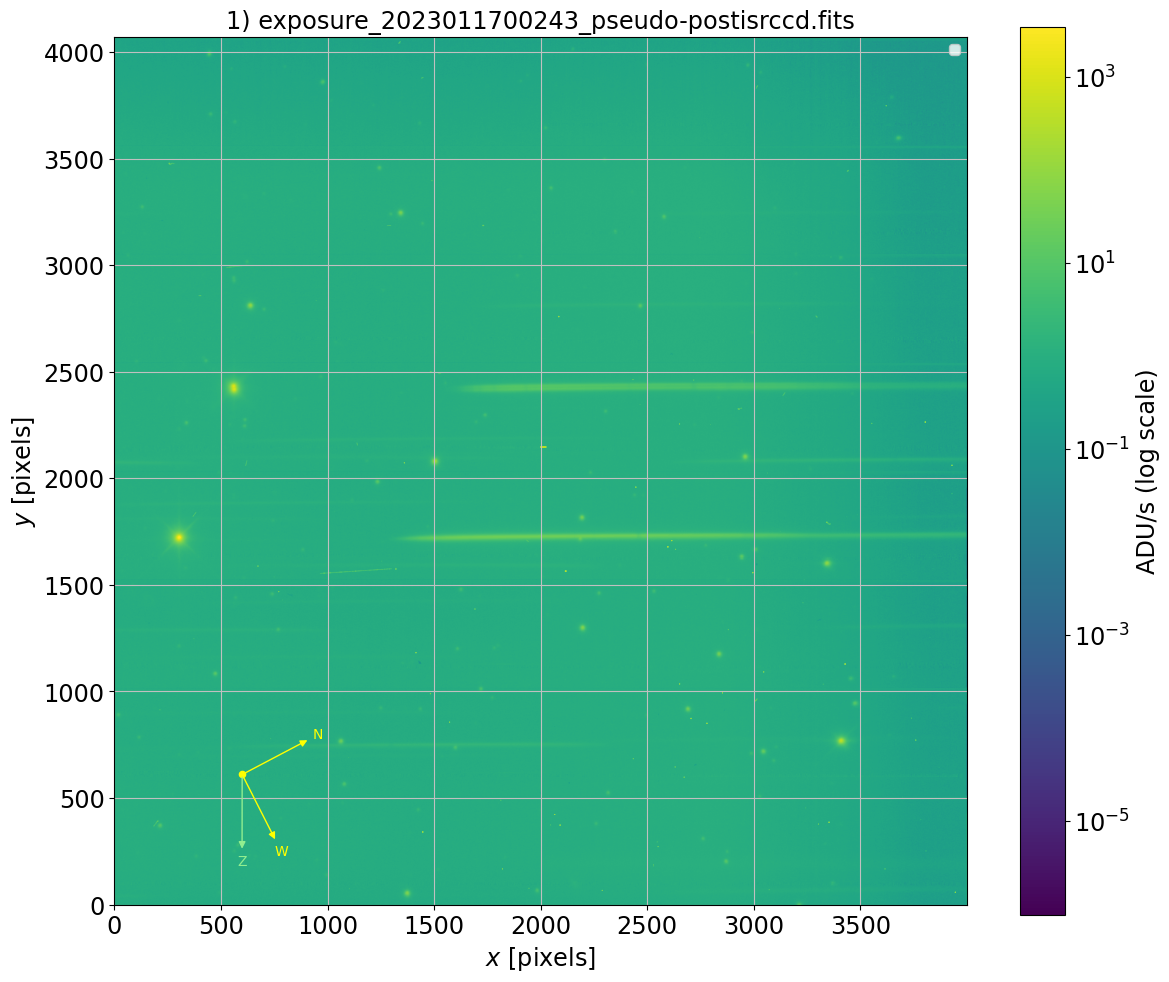

In [66]:
import matplotlib.pyplot as plt
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)
plt.show()

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [67]:
filename_image

'exposure_2023011700243_pseudo-postisrccd.fits'

## Let Spectractor find the location of the 0th order

2023-07-18 16:12:33  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                  c0_1        
    ------------------ --------------------- ---------------------
    1.8463681504620815 -0.005905243819699695 0.0028415511923086624
2023-07-18 16:12:33  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 8 iterations because the relative change of cost is below ftol=1.25e-05.


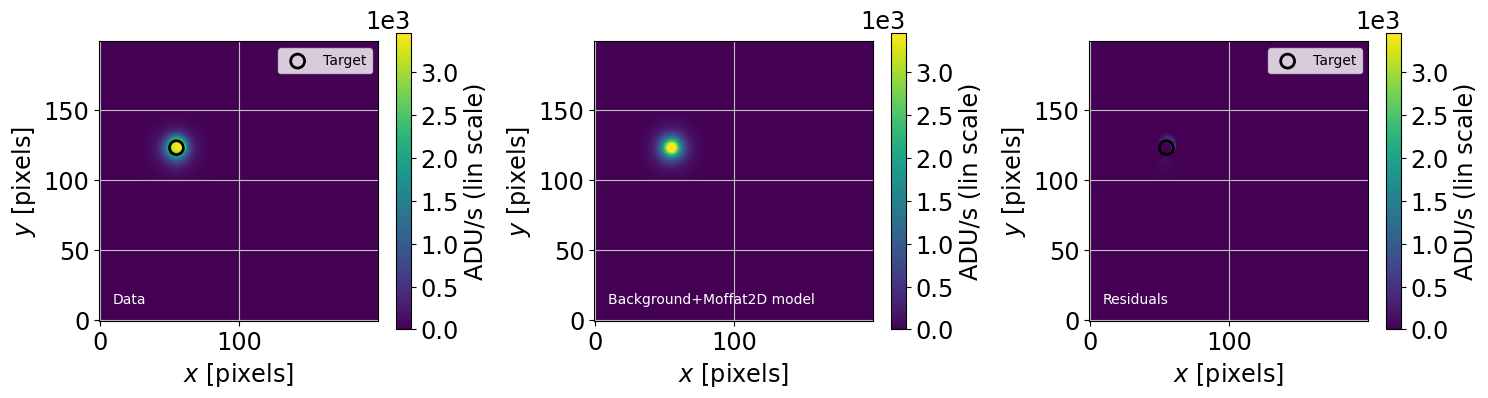

2023-07-18 16:12:34  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


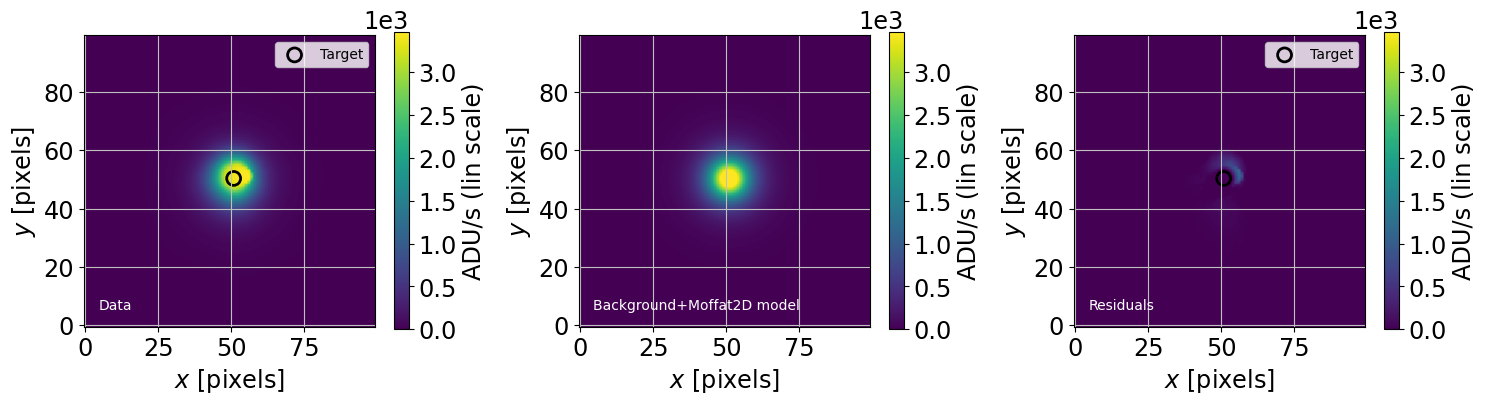

In [68]:
parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [69]:
print(x1,y1)

304.8844351267488 1723.3439414998463


## Check the location of 0th order and Analysis of the quality of its focus

In [70]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [71]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [72]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [73]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [74]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [75]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [76]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [77]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [78]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [79]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [80]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [81]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [82]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

Text(0.5, 0.98, '1) exposure_2023011700243_pseudo-postisrccd.fits')

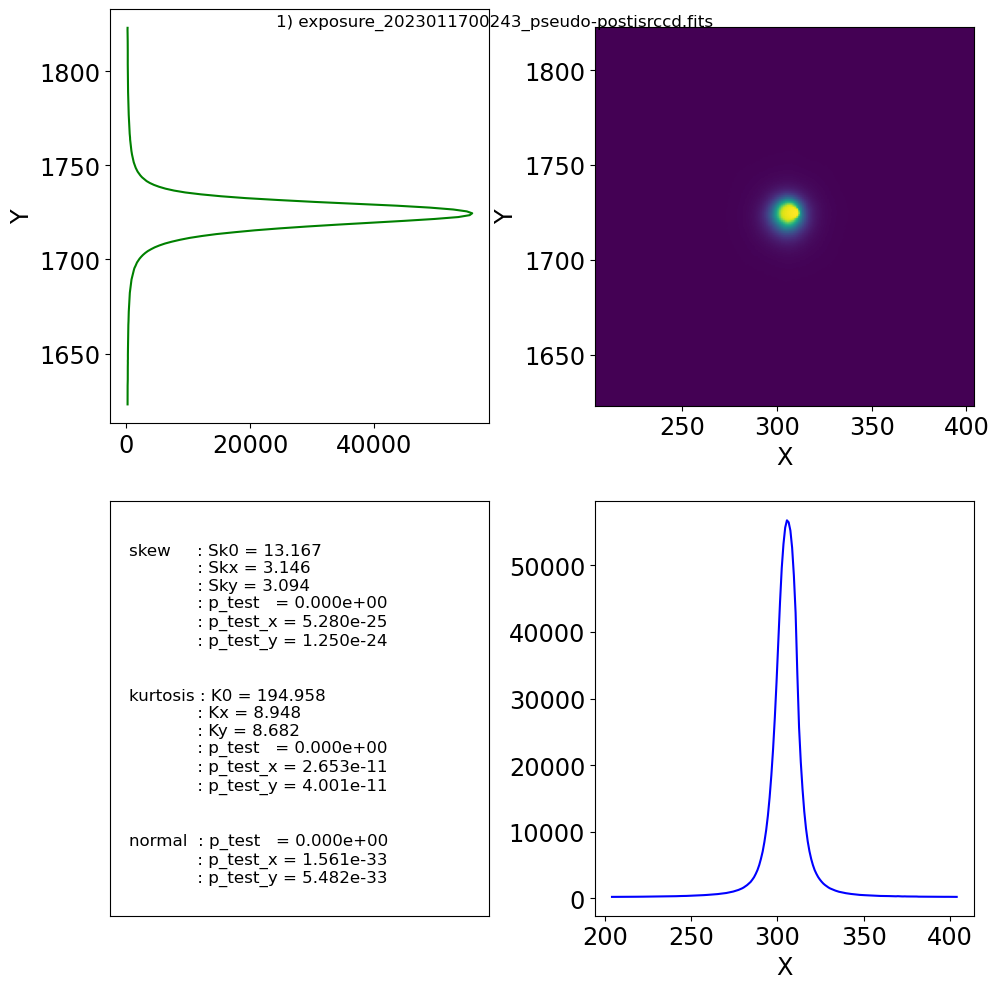

In [83]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title)

In [84]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [85]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

parameters.DEBUG=True
parameters.VERBOSE=True
parameters.DISPLAY=True
parameters.LIVE_FIT=False

In [86]:
filename

'/Users/sylvie/DATA/AuxTelData2023/data/2023/empty~holo4_003/20230117/exposure_2023011700243_pseudo-postisrccd.fits'

In [87]:
output_directory

'./outputs_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2'

2023-07-18 16:12:37  spectractor.extractor.extractor SpectractorInit      INFO   
	Spectractor initialisation
2023-07-18 16:12:37  spectractor.config load_config          INFO   
	Loading ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini with parameters.VERBOSE=True...
2023-07-18 16:12:37  spectractor.config load_config          INFO   Loaded ./config/auxtel_config_holo_DECONVOLUTION_FFMv_REBIN2_Janv2023.ini with
Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTIO

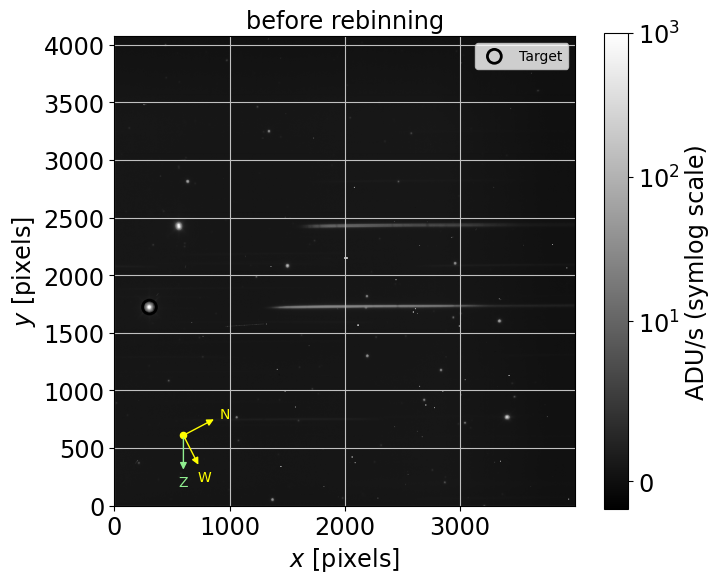

2023-07-18 16:12:47  spectractor.extractor.extractor SpectractorRun       INFO   
	  ======================= REBIN =============================


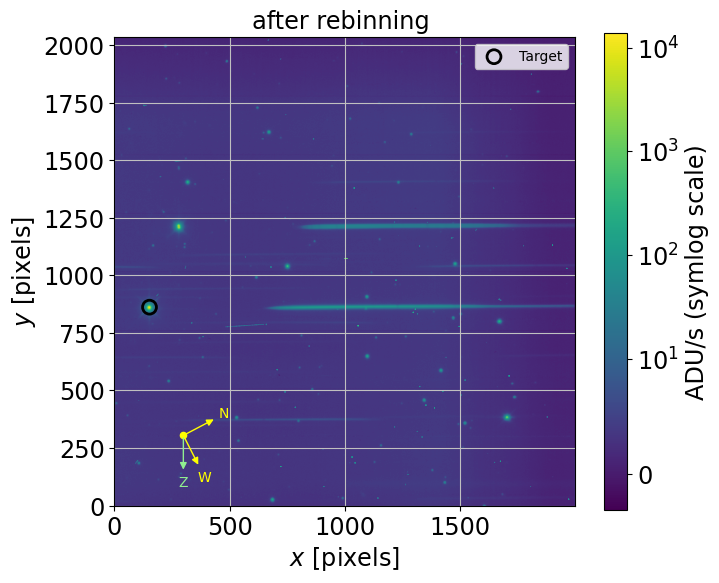

2023-07-18 16:12:50  spectractor.extractor.extractor SpectractorRun       INFO   
	Search for the target in the image with guess=[152.44221756 861.67197075]...
2023-07-18 16:12:50  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                   c0_1         
    ----------------- ---------------------- ----------------------
    5.847842940644206 -0.0001122685811522636 -0.0002777727724342464
2023-07-18 16:12:50  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=5e-05.


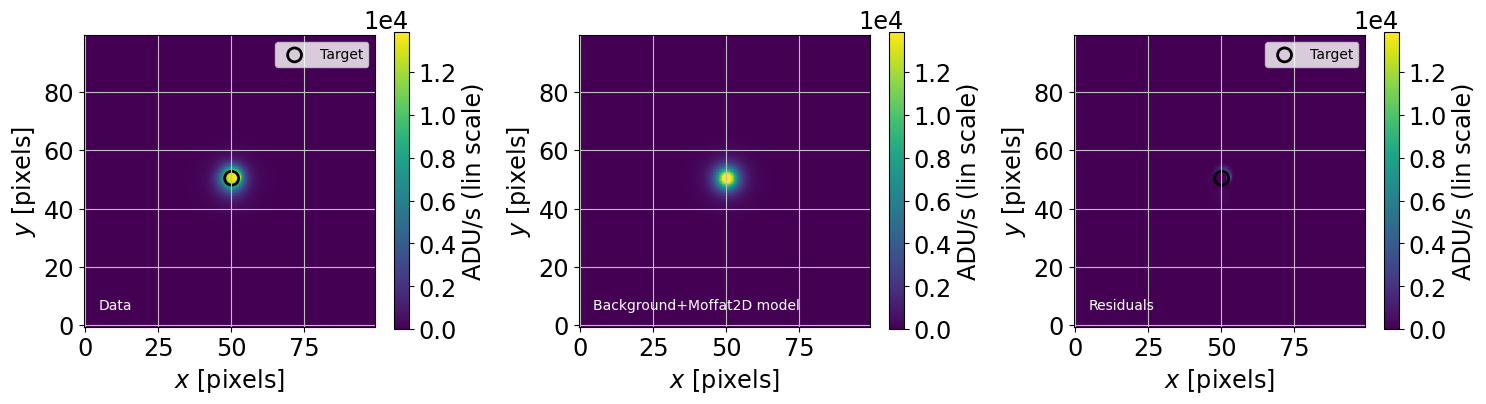

2023-07-18 16:12:50  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0002.


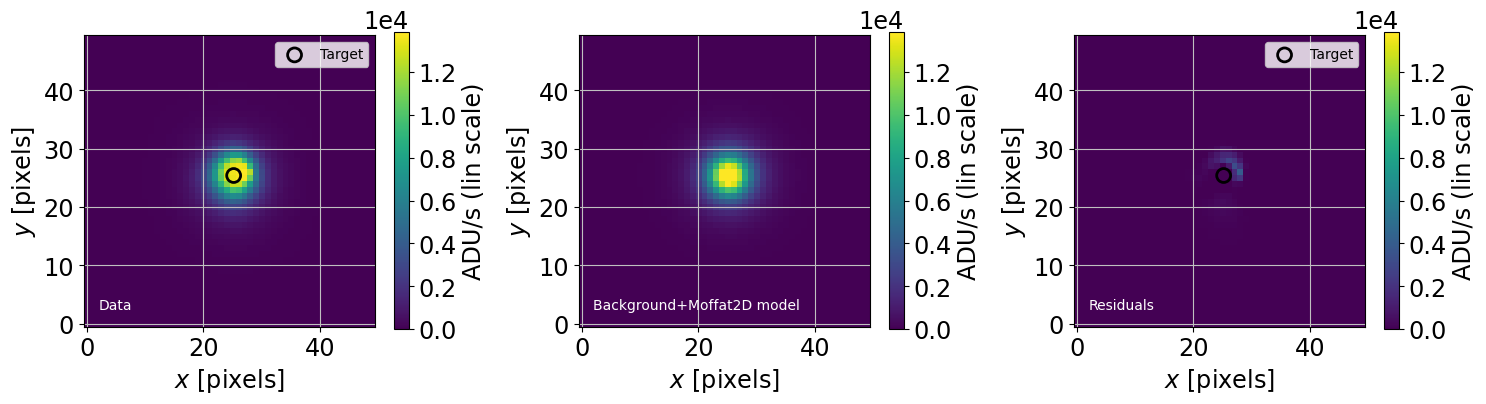

2023-07-18 16:12:51  Image      find_target          INFO   
	X,Y target position in pixels: 152.192,861.422
2023-07-18 16:12:51  Image      turn_image           INFO   
	Rotate the image with angle theta=0.20 degree from method disperser.


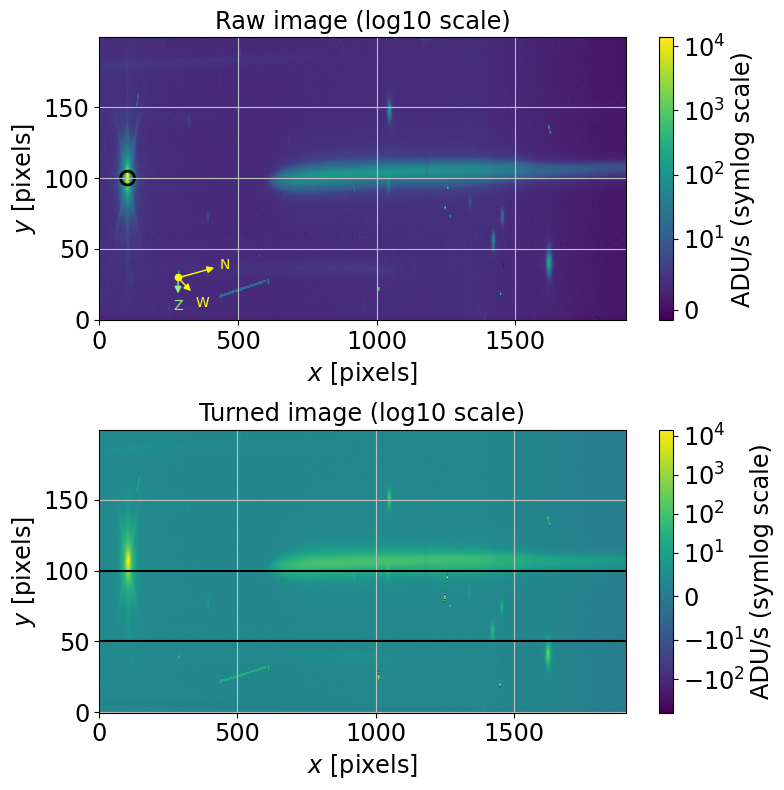

2023-07-18 16:12:55  spectractor.extractor.extractor SpectractorRun       INFO   
	Search for the target in the rotated image...
2023-07-18 16:12:55  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1       
    ----------------- --------------------- -------------------
    19.51852594630971 -0.003563955553757306 0.10066269331410929
2023-07-18 16:12:55  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


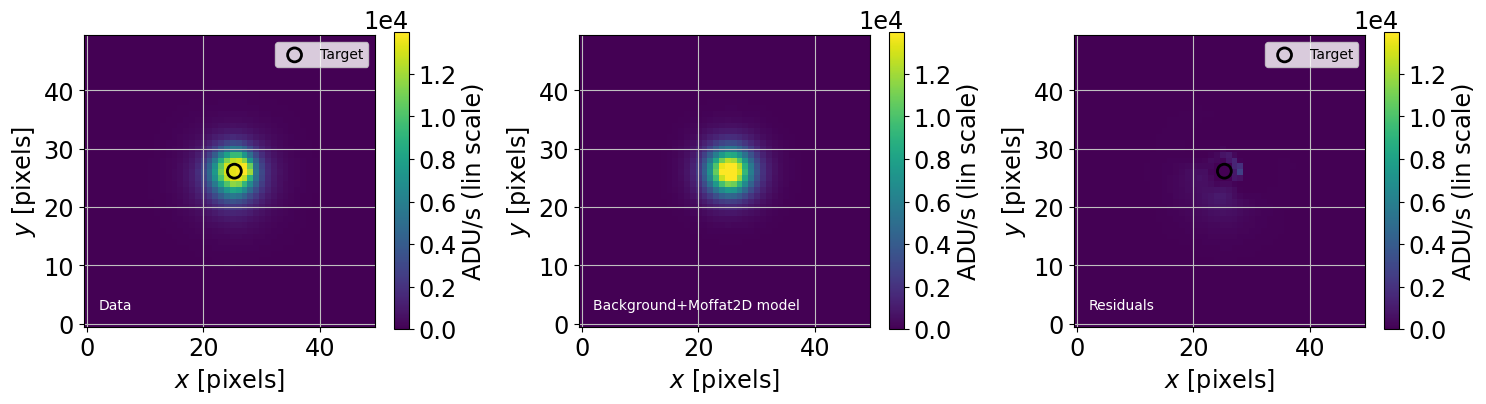

2023-07-18 16:12:56  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0008680555555555555.


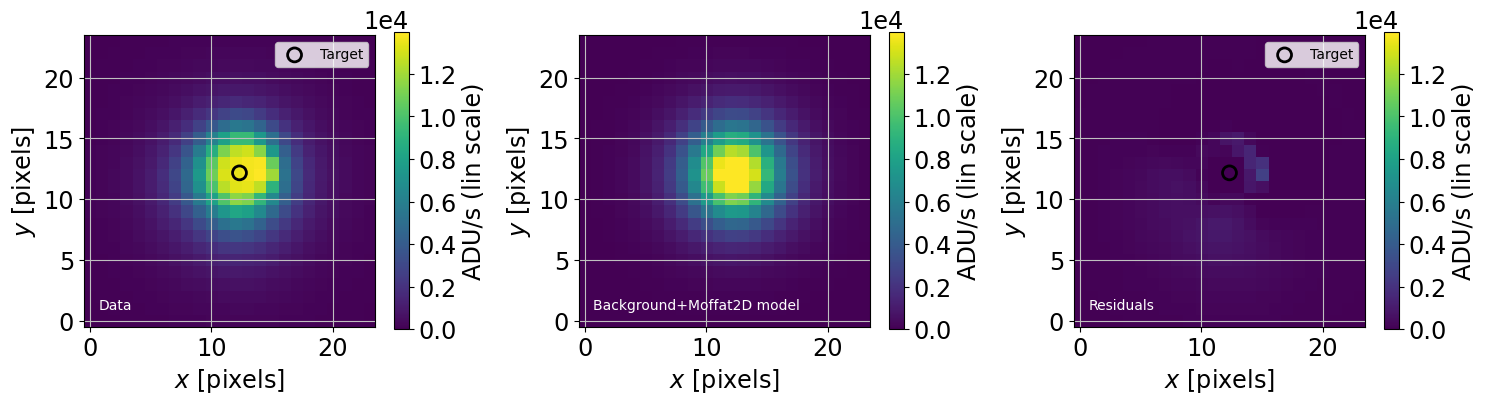

2023-07-18 16:12:57  Image      find_target          INFO   
	X,Y target position in pixels: 155.313,868.160
2023-07-18 16:12:57  Spectrum   __init__             INFO   
	Spectrum info copied from image
2023-07-18 16:12:57  spectractor.extractor.extractor SpectractorRun       INFO   
	 ======================== PSF1D Extraction ====================================
2023-07-18 16:12:57  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= extract_spectrum_from_image =============================
2023-07-18 16:12:57  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*10 pixels and background from 70 to 90 pixels
2023-07-18 16:12:57  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [574:1711,778:958] (size (1137, 180))


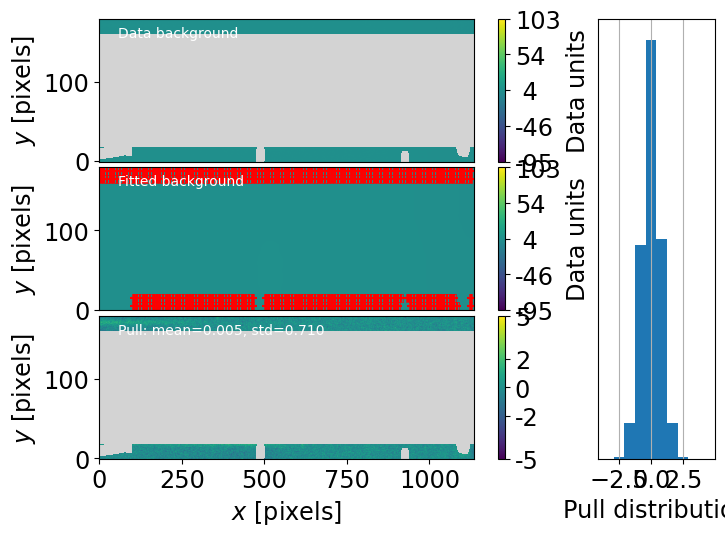

2023-07-18 16:12:58  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Fit the transverse profile =============================
2023-07-18 16:12:58  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/Users/sylvie/mambaforge/lib/python3.10/site-packages/Spectractor-2.5-py3.10.egg/spectractor/extractor/psf.py:717: RuntimeWarning: invalid value encountered in scalar divide
  norm = gamma * np.sqrt(np.pi) * special.gamma(alpha - 0.5) / special.gamma(alpha)


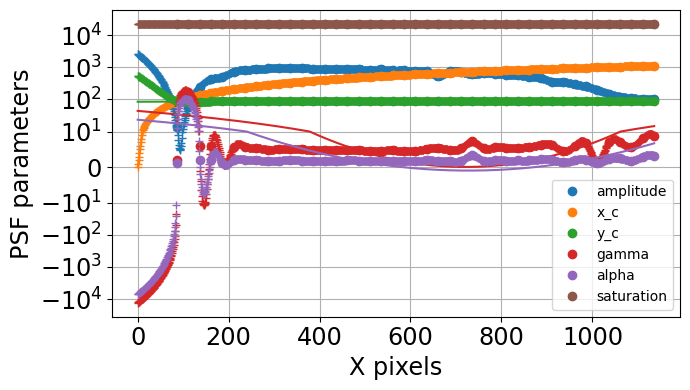

2023-07-18 16:13:00  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	initial cost=1.4948e+05	initial chisq_red=6.5732
2023-07-18 16:13:00  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	final cost=1.3777e+05	final chisq_red=6.0585 	computed in 0.42s
2023-07-18 16:13:01  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1:	final cost=1.3762e+05	final chisq_red=6.0521 	computed in 0.44s
2023-07-18 16:13:01  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=2:	final cost=1.3762e+05	final chisq_red=6.052 	computed in 0.45s
2023-07-18 16:13:01  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=4.397537379067722e-05.
2023-07-18 16:13:01  ChromaticPSF1DFitWorkspace run_gradient_descent INFO   
	x_c_0: 986.6872729385191 (fixed)
	x_c_1: 567.9999999999998 (fixed)
	x_c_2: -6.117639124190535e-13 (fixed)
	y_c_0: -1.182 +0.002 -0.002
	y_c_1: 

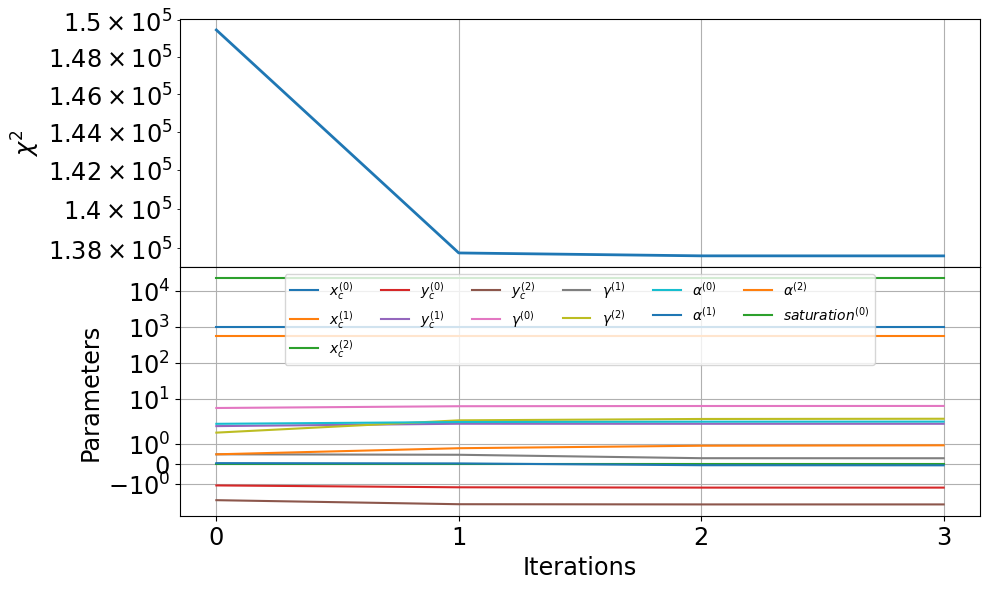

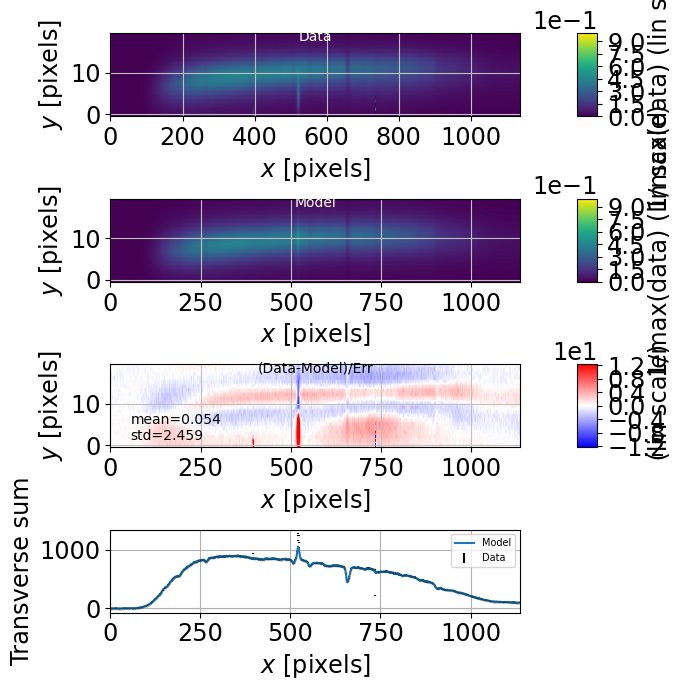

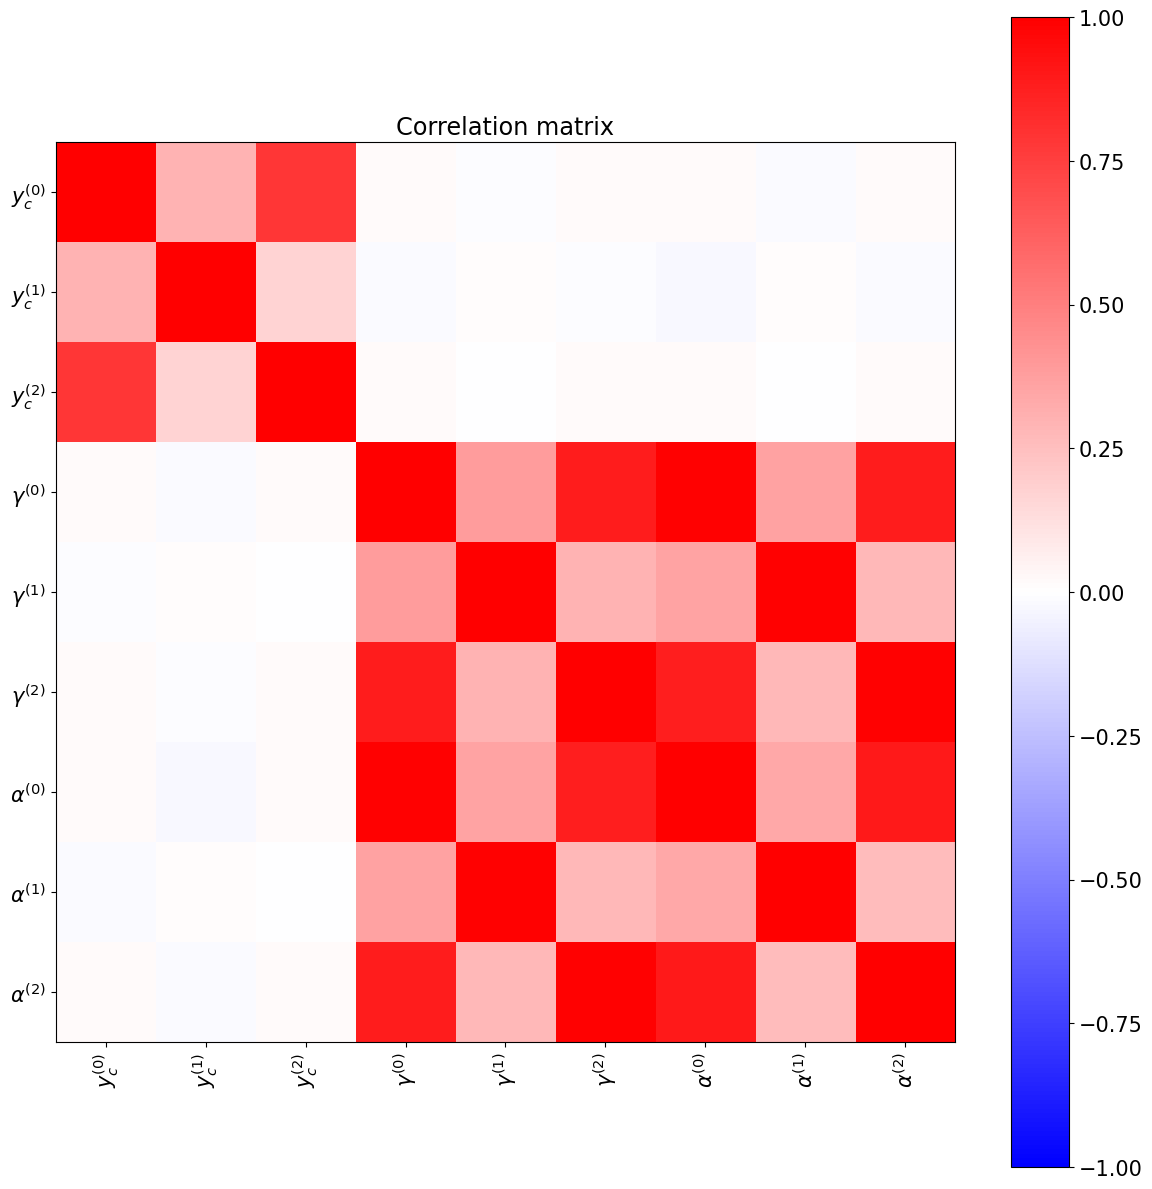

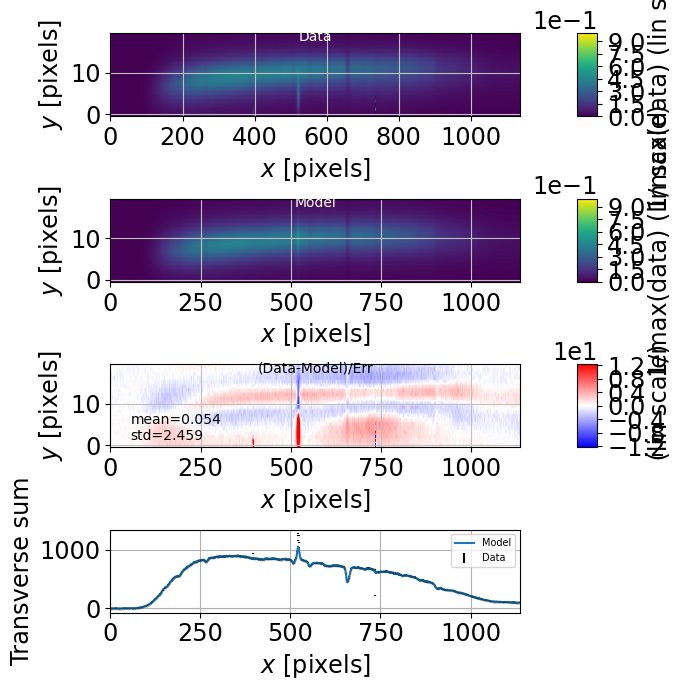

2023-07-18 16:13:06  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop raw image [570:1707,772:957] (size (1137, 185))
2023-07-18 16:13:06  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= Extract the non rotated background  =============================


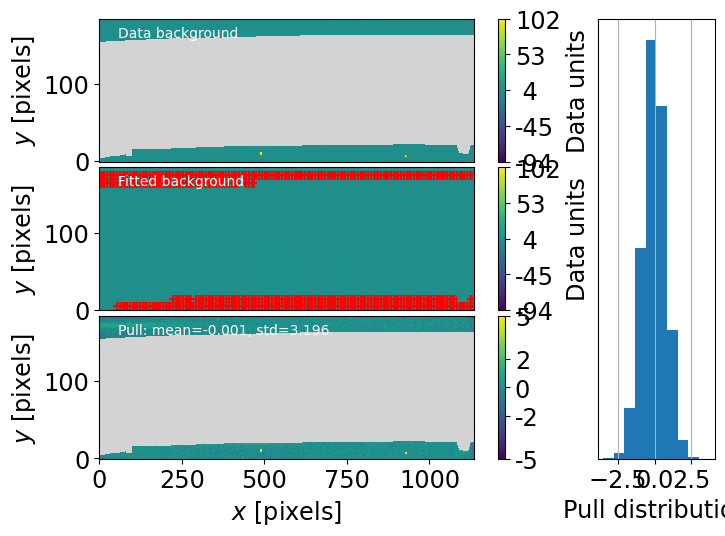

2023-07-18 16:13:08  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=3.491 ADU/s, RMS=0.454 ADU/s.
2023-07-18 16:13:08  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	  ======================= first guess for lambdas  =============================
2023-07-18 16:13:08  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [570:1707,772:957] (size (1137, 185))
	New target position in spectrogram frame: [-417.8076874205102, 89.42244651060173]


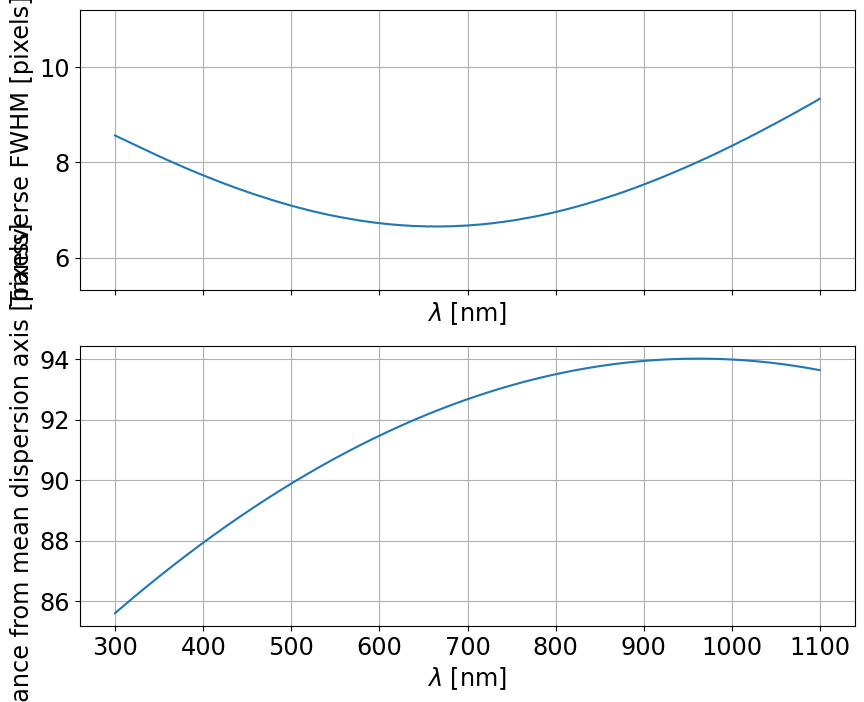

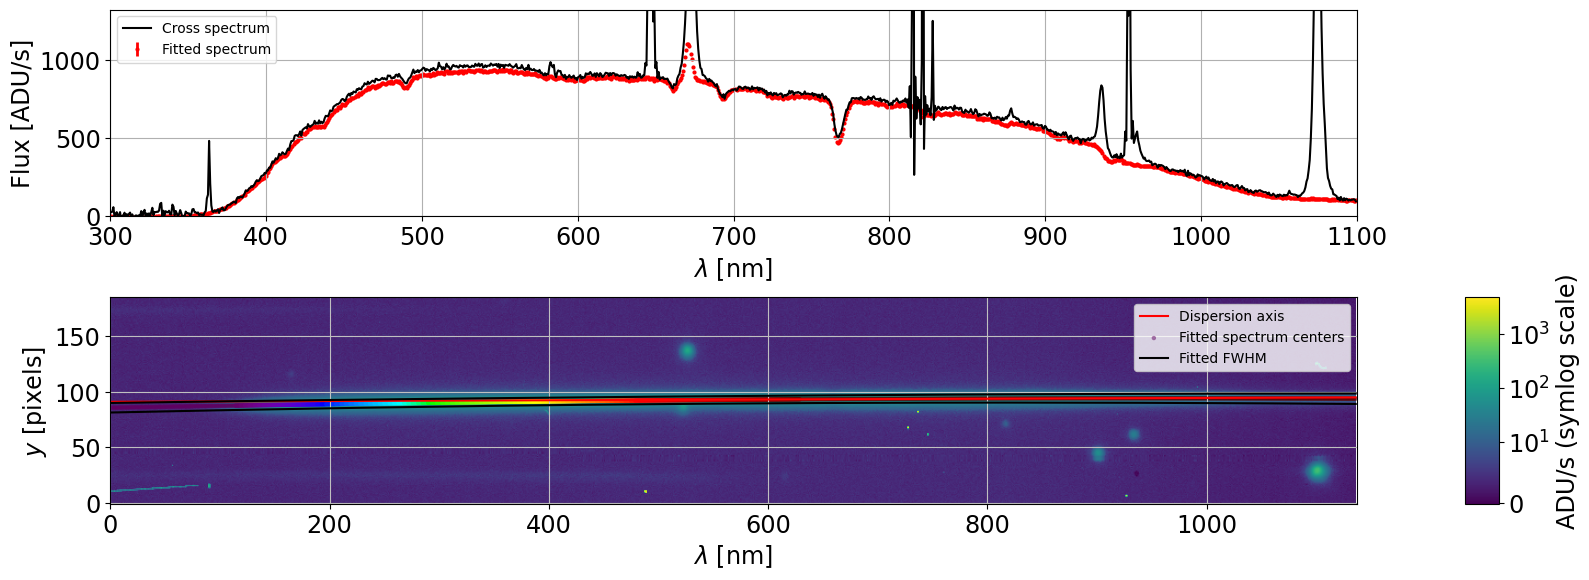

2023-07-18 16:13:09  spectractor.extractor.extractor SpectractorRun       INFO   
	Calibrating order 1 spectrum...


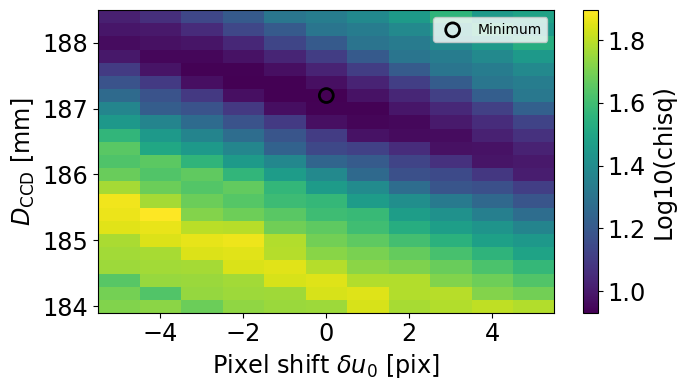

2023-07-18 16:13:21  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -0.406pix
	D = 187.178 mm (default: DISTANCE2CCD = 186.00 +/- 0.40 mm, 2.9 sigma shift)
2023-07-18 16:13:21  spectractor.extractor.extractor SpectractorRun       INFO   
	  ======================= FFM DECONVOLUTION =============================
2023-07-18 16:13:21  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2023-07-18 16:13:23  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=0.1.
2023-07-18 16:13:23  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start FFM with adjust_spectrogram_position_parameters.
2023-07-18 16:13:25  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	initial cost=8.7358e+05	initial chisq_red=30.733
2023-07-18 16:13:33  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0:	final cost=6.8741e+05	final chisq_red=24

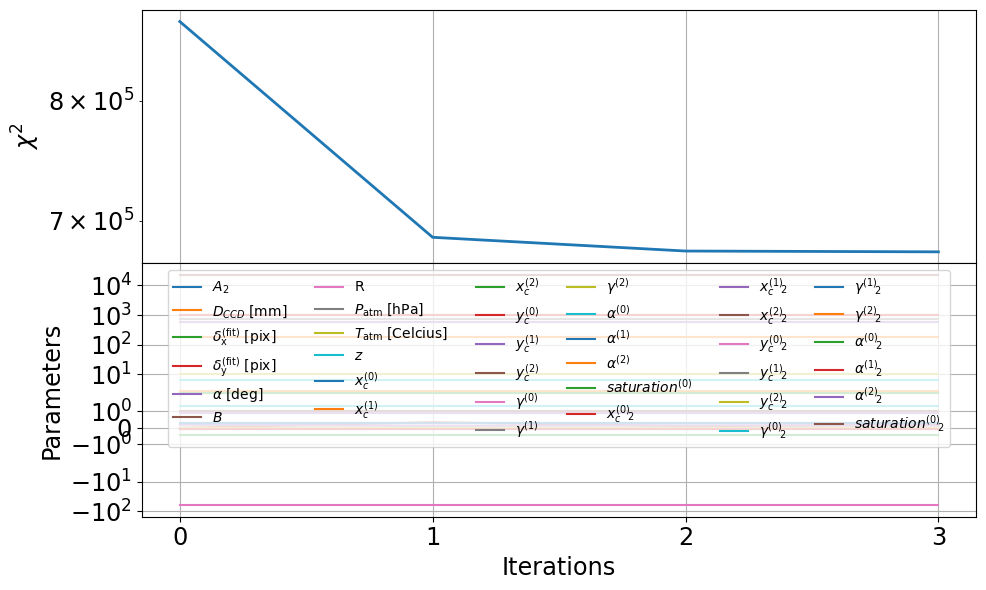

2023-07-18 16:13:51  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2/ffm_bestfit.pdf.
2023-07-18 16:13:53  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2/ffm_bestfit_2.pdf.


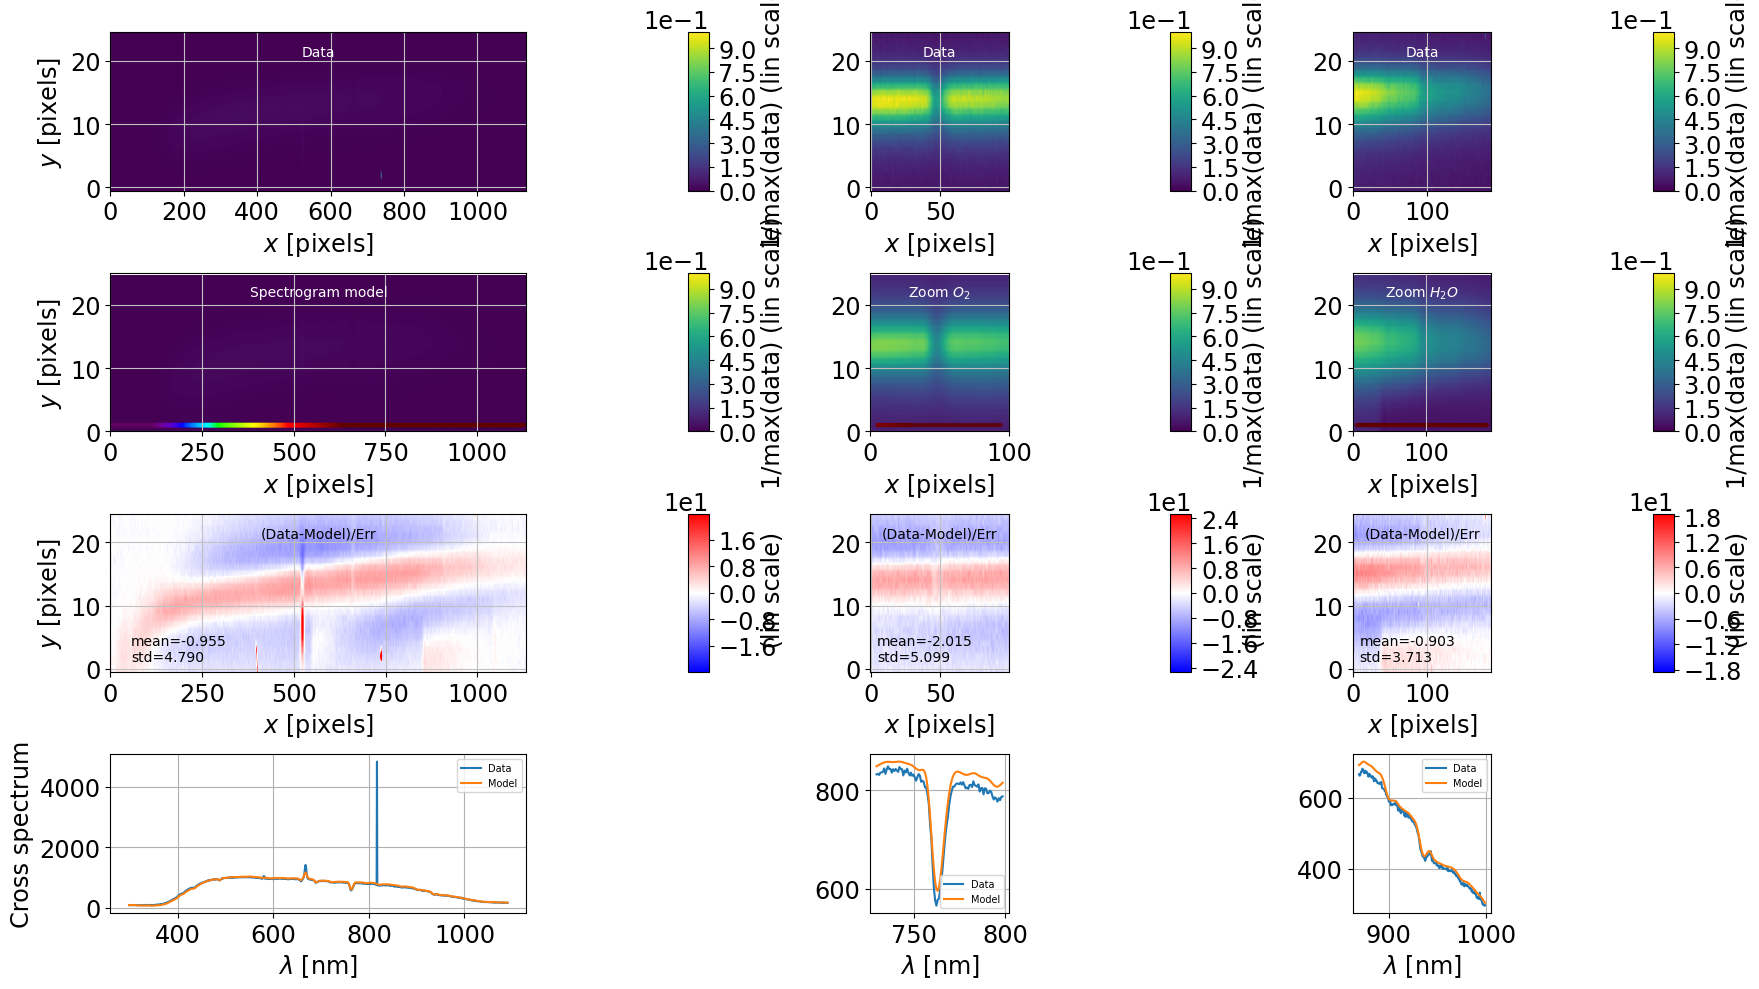

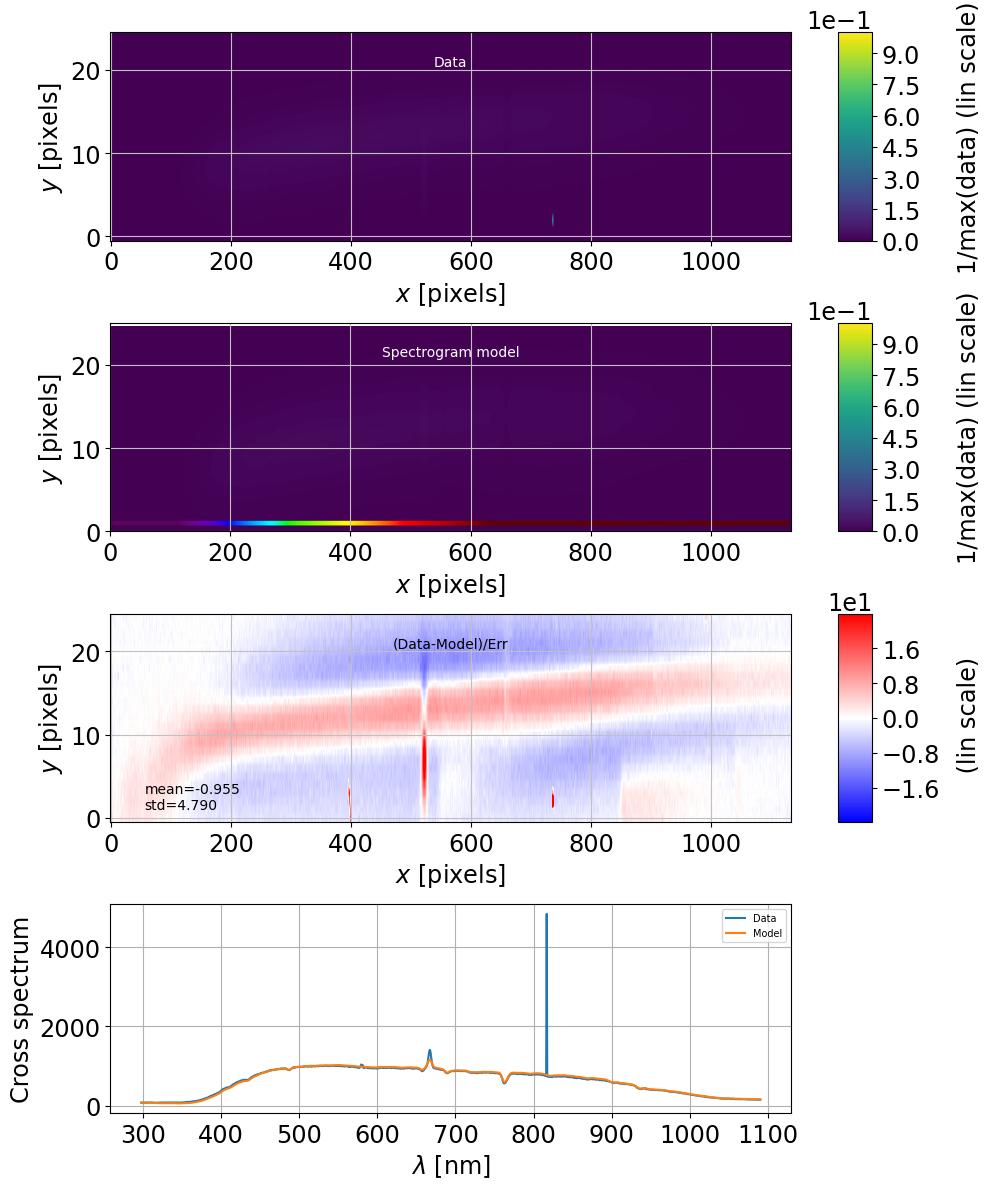

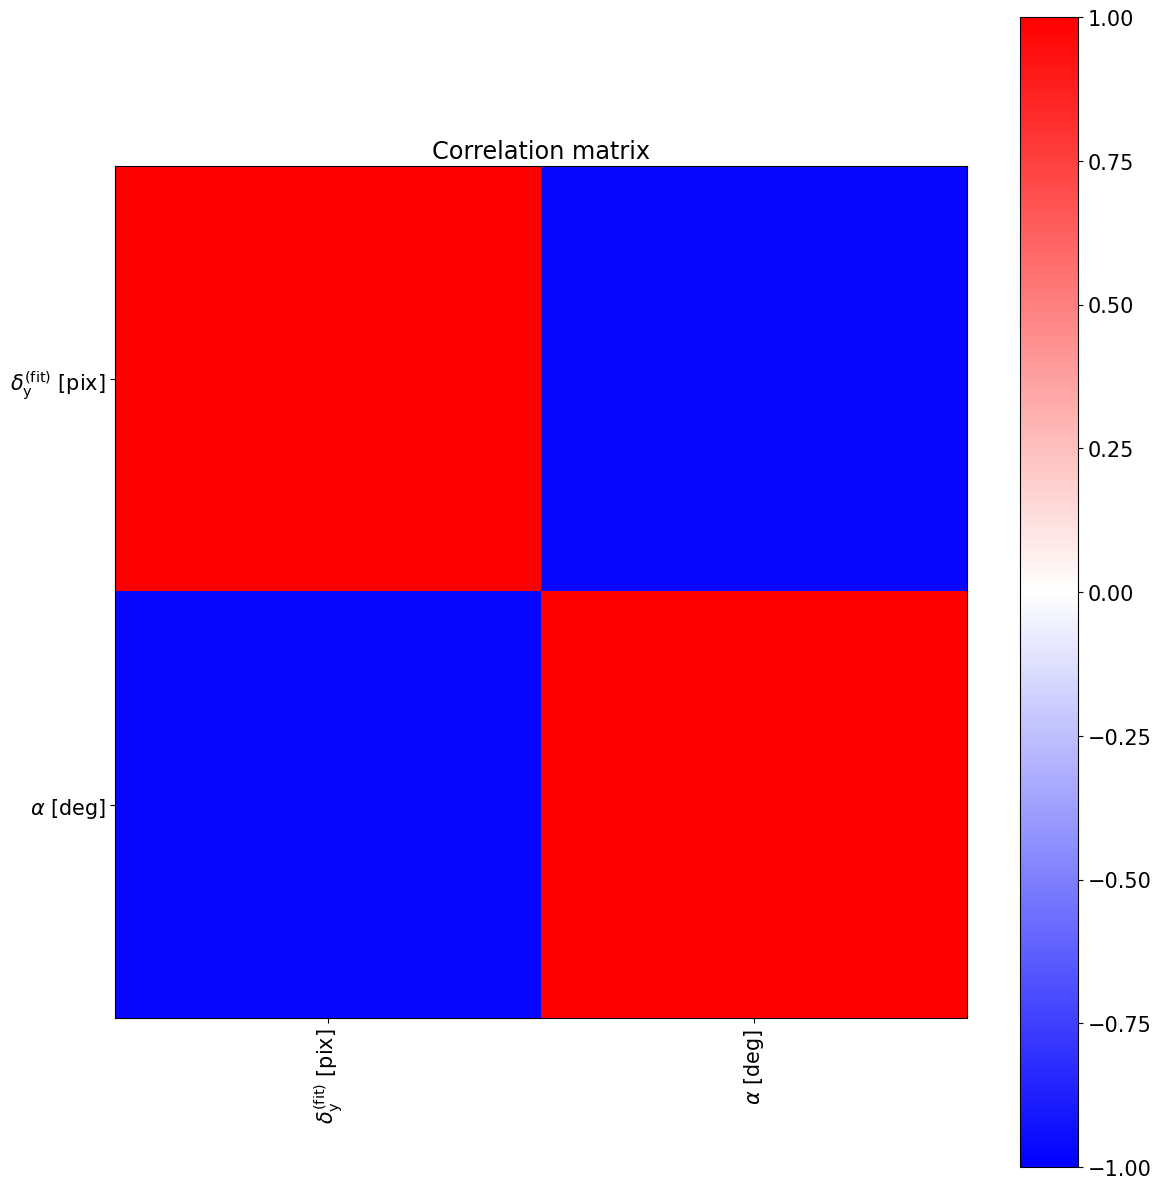

2023-07-18 16:13:56  FullForwardModelFitWorkspace set_mask             INFO   
	Reset spectrogram mask with current parameters.
2023-07-18 16:13:59  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2/ffm_bestfit.pdf.
2023-07-18 16:14:01  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure ./figures_process_20230117_empty~holo4_003_config_DECONVOLUTION_FFMv_REBIN2_Janv2023_nb_2/ffm_bestfit_2.pdf.


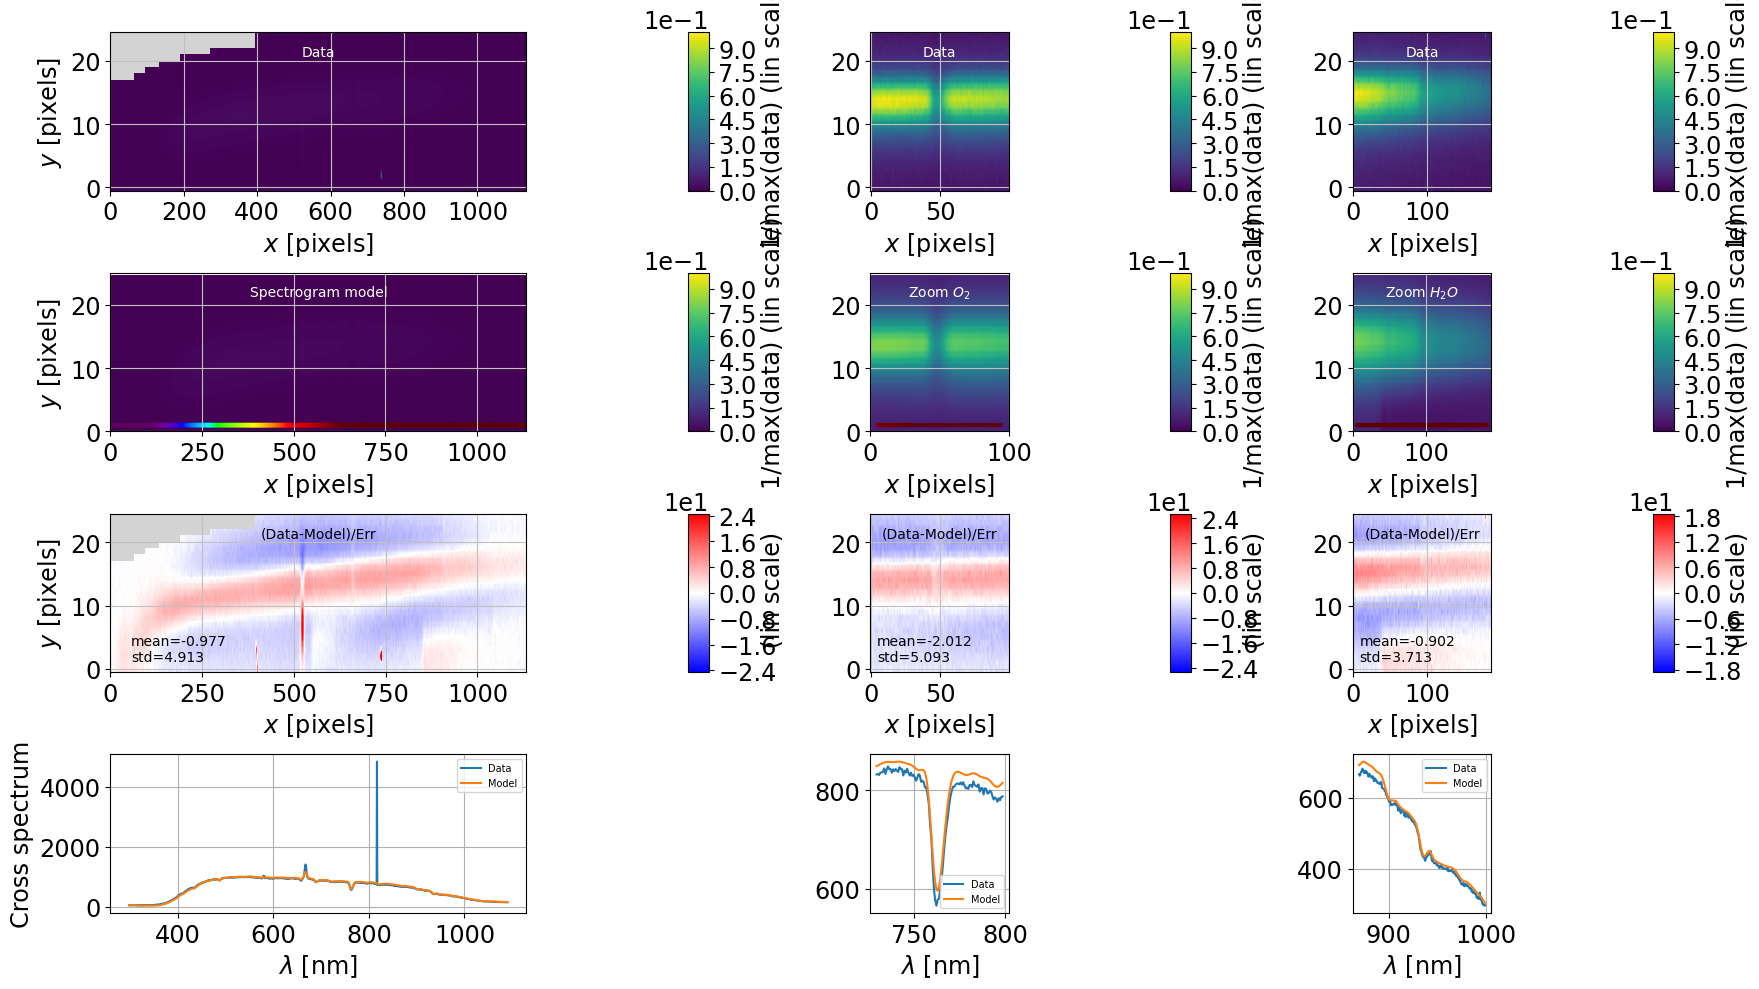

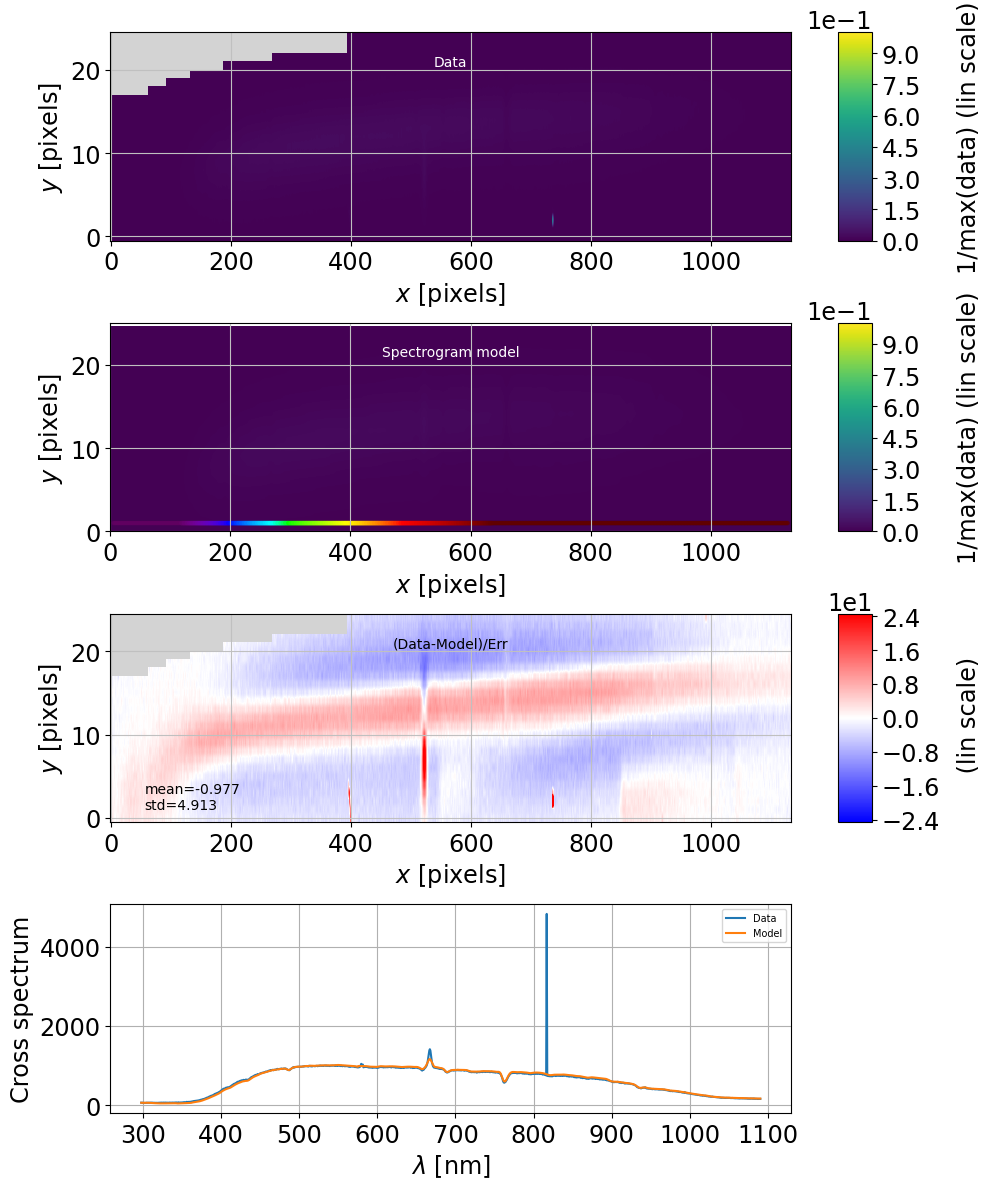

2023-07-18 16:14:03  spectractor.extractor.extractor run_ffm_minimisation INFO   	Start guess:
	A2: 1.0 (fixed=True)
	D_CCD [mm]: 187.17790356535207 (fixed=True)
	shift_x [pix]: -0.40626620044645656 (fixed=True)
	shift_y [pix]: 0.18491460856105024 (fixed=True)
	angle [deg]: 0.15283138732121349 (fixed=True)
	B: 1.0 (fixed=True)
	R: -62.65735697195652 (fixed=True)
	P [hPa]: 744.0 (fixed=True)
	T [Celsius]: 10.0 (fixed=True)
	z: 1.335267001314697 (fixed=True)
	x_c_0: 986.6812617019988 (fixed=True)
	x_c_1: 567.996539549625 (fixed=True)
	x_c_2: -9.695506531652684e-13 (fixed=True)
	y_c_0: 0.0 (fixed=False)
	y_c_1: 0.0 (fixed=False)
	y_c_2: 0.0 (fixed=False)
	gamma_0: 6.408551017958591 (fixed=False)
	gamma_1: 0.2896565236317974 (fixed=False)
	gamma_2: 2.8201818144326003 (fixed=False)
	alpha_0: 2.347710586325186 (fixed=False)
	alpha_1: -0.06554131613044312 (fixed=False)
	alpha_2: 0.9380214512632701 (fixed=False)
	saturation_0: 22666.66666666667 (fixed=True)
	x_c_0_2: 986.6812617019988 (fixed=T

In [ ]:
if FLAG_RUNWITHEXCEPTIONS:
    try:
        spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)
    except:
        errtype = sys.exc_info()[0]  # E.g. <class 'PermissionError'>
        description = sys.exc_info()[1]   # E.g. [Errno 13] Permission denied: ...
        
        print("\t +++++++++++++++++++++ Exception occured +++++++++++++++++++++++++++++++++++++++++")
        print(f"\t >>>>>  errtype = {errtype}")
        print(f"\t >>>>>> description = {description}")
else:
    spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target_name_sel, disperser_label=disperser_label, config=config)

In [ ]:
spectrum.plot_spectrum(force_lines=True) 

# Backup output

- If no crash occurs, arrive here

./outputs_process_holo_config_DECONVOLUTION_PSF2D

In [ ]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [ ]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    
    if not os.path.isdir(path_toptoptopoutput_spectractor):
        os.mkdir(path_toptoptopoutput_spectractor)
    
    if not os.path.isdir(path_toptopoutput_spectractor):
        os.mkdir(path_toptopoutput_spectractor) 
        
    if configdir !="":
    # top directory    
        if not os.path.isdir(path_topoutput_spectractor):
            os.mkdir(path_topoutput_spectractor)   
            
            
        if not os.path.isdir(path_output_spectractor):
            os.mkdir(path_output_spectractor)
  
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("******************************** SUCCESS ********************************************")

In [ ]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
print("finalpath_output_spectractor = ",finalpath_output_spectractor)

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"basespec"))

In [ ]:
os.listdir(os.path.join(finalpath_output_spectractor,"plots"))

In [ ]:
output_directory